# Task 1. Data Collection

Scraping data from complete set of web pages

---

In [1]:
# importing modules
import urllib.request
import bs4
import pandas as pd
import re
from pathlib import Path

%load_ext nb_black

<IPython.core.display.Javascript object>

Checking and Creating directory structure if doesn't exist.

In [2]:
dir_data = Path("data")
dir_data.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

Fetching the url using library and decoding it to 'html' variable

In [3]:
raw_link = "http://mlg.ucd.ie/modules/python/assign2/21200098"
response = urllib.request.urlopen(raw_link)
html = response.read().decode()

<IPython.core.display.Javascript object>

Creating a function to fetch the links

In [4]:
def get_links(mytag):
    a_links = (mytag.find_next("div", class_="list-group")).findAll("a")
    return [a["href"] for a in a_links]

<IPython.core.display.Javascript object>

Creating a year_dict which contains year number with a list of all the monthly links

In [5]:
parser = bs4.BeautifulSoup(html, "html.parser")
years_list = parser.findAll("div", class_="list-title")
year_dict = {}
for i in range(len(years_list)):
    year = (re.findall(r"\d+", years_list[i].get_text()))[0]
    year_dict[year] = get_links(years_list[i])

<IPython.core.display.Javascript object>

Fetching data from website and storing it into df_dict dictionary

In [6]:
df_dict = {"year": [], "title": [], "metadata": [], "star_rating": [], "review": []}
for year in year_dict:
    for link in year_dict[year]:
        link = f"{raw_link}/{link}"
        response = urllib.request.urlopen(link)
        html = response.read().decode()
        parser = bs4.BeautifulSoup(html, "html.parser")
        total_pages = int((parser.find("h4", class_="results").get_text())[-1])
        for i in range(1, total_pages + 1):
            if i>1:
                suffix = link.replace(".html", "")
                suffix = f"{suffix[:-1]}{i}"
                link = f"{suffix}.html"
                response = urllib.request.urlopen(link)
                html = response.read().decode()
                parser = bs4.BeautifulSoup(html, "html.parser")
            for match in parser.find_all("div", class_=["review", "review-alt"]):
                df_dict["year"].append(year)
                title_text = match.find("h5").get_text().replace("\u00a0", "")
                df_dict["title"].append(title_text)
                metadata_text=match.findAll("p", class_="metadata")[1].get_text()
                df_dict["metadata"].append(metadata_text)
                rating_text=((match.find("h5")).find("img"))["alt"].replace("-star", "")
                df_dict["star_rating"].append(rating_text)
                review_text=match.find("p", class_="review-body").get_text()
                df_dict["review"].append(review_text)


<IPython.core.display.Javascript object>

Saving the data to json format

In [7]:
df = pd.DataFrame.from_dict(df_dict, orient="index").transpose()
df["year"] = pd.to_numeric(df["year"])
df["star_rating"] = pd.to_numeric(df["star_rating"])
fname = "full_data.json"
out_path = dir_data / fname
print(f"Writing {out_path}")
df.to_json(out_path, orient="index", indent=4)

Writing data\full_data.json


<IPython.core.display.Javascript object>

In [8]:
df.dtypes

year            int64
title          object
metadata       object
star_rating     int64
review         object
dtype: object

<IPython.core.display.Javascript object>

No missing values found


<AxesSubplot:>

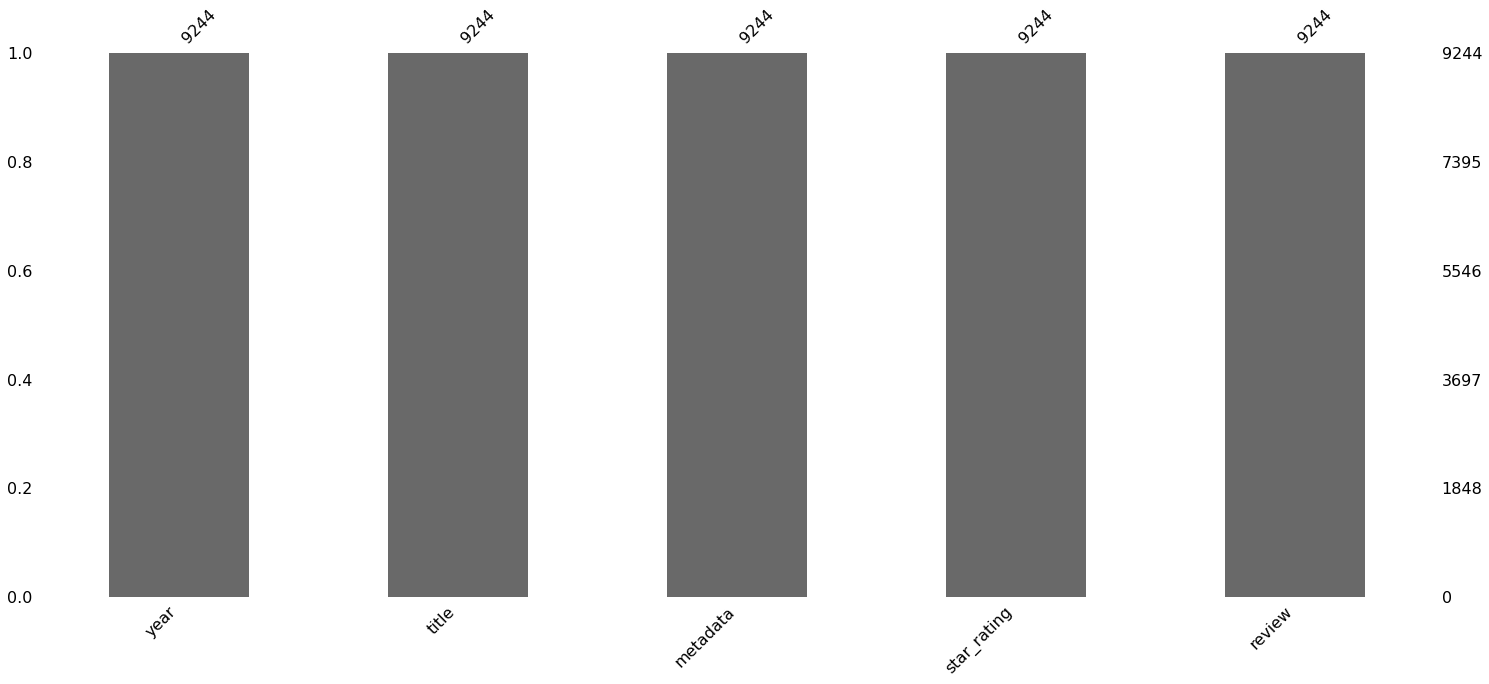

<IPython.core.display.Javascript object>

In [9]:
import missingno as msno

missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) == 0:
    print("No missing values found")
else:
    print(f"Missing count: {missing_counts}")
msno.bar(df)